# Swift UVOT Events

## Reading in Data

import the necessary packages, download files, and clean the data.

In [538]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import TimeSeries
from astropy.timeseries import BinnedTimeSeries
from astropy.timeseries import aggregate_downsample
from astropy import units as u
from astropy.time import Time
from astropy.time import TimeGPS
from astropy.table import vstack

from regions import CircleSkyRegion
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import wget

In [2]:
## download the files locally

eventDataUrl = 'https://www.swift.ac.uk/archive/reproc/00094137009/uvot/event/sw00094137009um2w1po_uf.evt.gz'
imgDataUrl = 'https://www.swift.ac.uk/archive/reproc/00094137009/uvot/products/sw00094137009u_sk.img.gz'

eventPath = 'sw00094137009um2w1po_uf.evt.gz'
imgPath = 'sw00094137009u_sk.img.gz'

try:
    wget.download(eventDataUrl, eventPath)
    wget.download(imgDataUrl, imgPath)
    print('Downloaded files')
    
except:
    print('Error downloading files')

Error downloading files


In [3]:
## open files after downloading them locally; no need to change the file path

eventFile = fits.open('sw00094137009um2w1po_uf.evt.gz')
imgFile = fits.open('sw00094137009u_sk.img.gz')

primaryHdu = imgFile[0]
imgHdu = imgFile[1]

wcs = WCS(imgHdu.header)

events = eventFile[1].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59236.264051 from DATE-OBS.
Set MJD-END to 59236.548553 from DATE-END'. [astropy.wcs.wcs]


In [4]:
print(events)

[(6.32983520e+08,   1867,   1370, 1916, 1439, 2238, 1547, 1,   0)
 (6.32983520e+08,   1534,   1402, 1593, 1476, 2137, 1857, 1,   0)
 (6.32983520e+08,   2039,   1420, 2079, 1486, 2348, 1419, 1,   0) ...
 (6.33013801e+08,   1164,   1636, 1229, 1718, 2616, 2093, 6, 256)
 (6.33013801e+08,    347,   1727,  432, 1810, 2294, 2827, 6, 256)
 (6.33013801e+08,   1453,   1997, 1503, 2069, 3058, 2034, 6, 256)]


In [5]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 116.110733 3.551811 
CRPIX : 1604.5 1583.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.000139444442 0.000139444442 
NAXIS : 3208  3166


### Cleaning Event Data

In [6]:
## removing events where the quality is not good, as marked by the telescope

events_good = events[np.where((events.QUALITY == 0))]
print(f'removed {len(events) - len(events_good)} events')

removed 1952995 events


In [14]:
## removing non-continuous data points (or floating chunks of data)

events_good.sort()
events_int = []
waiting_interval = [tuple(events_good[0])]

formats = events_good.dtype

eStart = events_good['TIME'][0]
eLast = events_good['TIME'][0]

for i in range(1, len(events_good)):
    eTime = events_good['TIME'][i]
    ## belongs to the same interval
    if (eTime - eLast < 5):
        waiting_interval.append(tuple(events_good[i]))
        eLast = eTime
    ## do not belong to the same interval
    else:
        ## save the interval if it is large
        ## if the interval does not have a lot of data, just discard it
        if (eTime - eStart > 80): 
            events_int += waiting_interval
        waiting_interval = []
        eStart = events_good['TIME'][i + 1]
        eLast = events_good['TIME'][i + 1]
        
## dealing with fencepost error 
if (waiting_interval[-1][0] - waiting_interval[0][0] > 80): 
    events_int += waiting_interval
    
## return cleaned events with same formats as original data
events_clean = np.array(events_int, dtype=formats)

In [15]:
## convert events to numpy record array

events_clean = events_clean.view(np.recarray)
print('removed', len(events_good) - len(events_clean), 'events')

removed 396177 events


In [631]:
## an interval used for debugging purposes

## middleInterval = events_clean[np.where((events_clean['TIME'] < 633003000) & (events_clean['TIME'] > 633000000))]

## Displaying Event Data

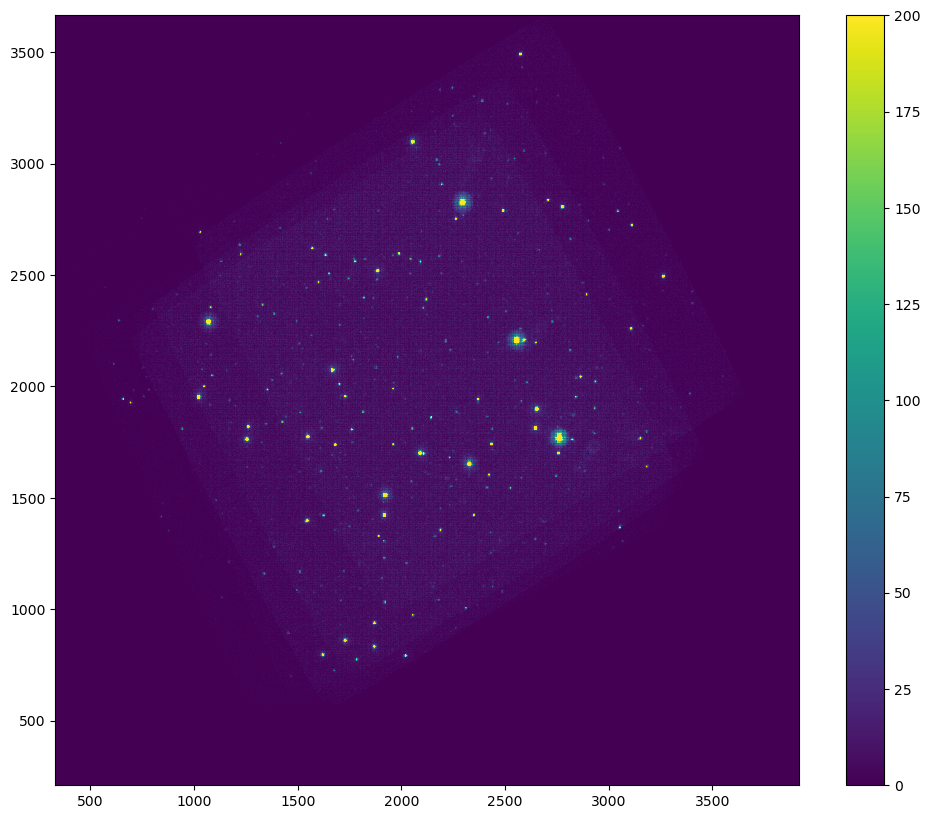

In [16]:
## displays all the data on a 2D histogram

fig, ax = plt.subplots(figsize=(12, 10))

## plt.subplot(projection=wcs)

histdata, x_bins, y_bins, img = plt.hist2d(events_clean.X, events_clean.Y, bins=1000, vmin=0, vmax=200)
plt.colorbar()
plt.show()

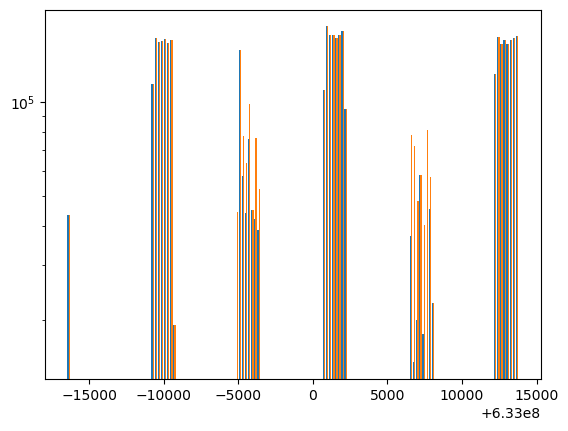

In [17]:
## a histogram of all the cleaned event times (blue) compared to the original event times (orange)
## it makes sense that orange has more data, since some of it is noncontinuous and is discarded

times = plt.hist([events_clean['TIME'], events_good['TIME']], bins='auto', log=True)
plt.show()

## Star-finding

finding stars so their data can be organized

In [18]:
## import annulus
## these stars are smaller, so we use the smaller annulus

from PIL import Image
im_frame = Image.open('annuli_imgs/annulus_22.png')

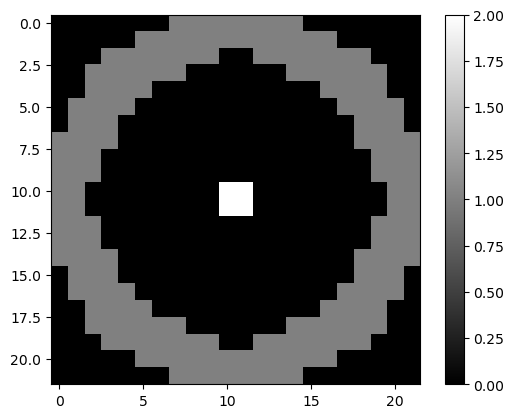

In [19]:
## fix up the imported annulus so that it's a 2D numpy array

np_frame = np.array(im_frame)
annulus_size = len(np_frame)

annulus = np.zeros((annulus_size, annulus_size))
for i in range(annulus_size):
    for j in range(annulus_size):
        ## background (annulus aperture)
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1
        ## star (circle aperture)
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2
            
plt.imshow(annulus, cmap='gray')
plt.colorbar()
plt.show()

### Signal to Noise Ratio

In [20]:
## signal-to-noise ratio function from counting_stars_v5

def calculate_ratio (testImg, x, y):
    ## summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    ## sky background per pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    ## signal in aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    ## total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    ## mainly what we care about is the background
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    ## catch divide-by-zero (preventative)
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

In [23]:
## calculating SNR for every single pixel on the image
testImg = histdata

snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calculate_ratio(testImg, i, j)

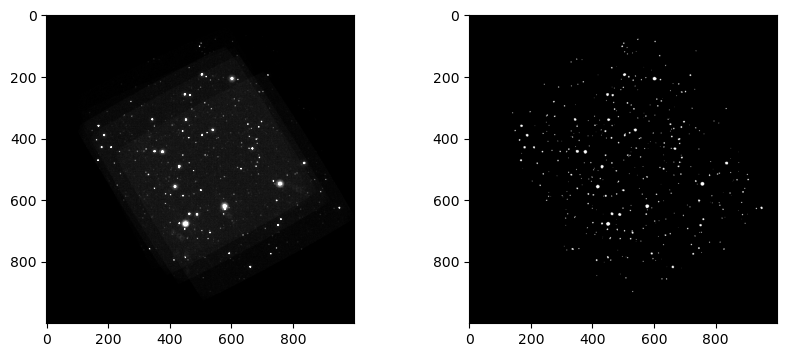

In [24]:
## set a basic threshold for the SNR
threshold = 5

## apply threshold on snrImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 100
        else:
            imgCut[i, j] = 0

## display the isolated stars 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].imshow(testImg, cmap='gray', vmin=0, vmax=100)
axes[1].imshow(imgCut, cmap='gray')
plt.show()

### Counting the Stars

In [25]:
## a simple function that returns if a pixel that's part of a star has a neighbor above and to the left of it

def hasNeighborAbove (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [26]:
## a matrix of T/F values for if there is a star at position i,j, where i,j corresponds to its position in testImg.
matrix = [[False for i in range(len(testImg[0]))] for j in range(len(testImg))]

## counting the total number of stars
count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 100):
            matrix[i][j] = True
            if (hasNeighborAbove(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [27]:
print('number of stars:', count)

number of stars: 408


## Star Data
Access stars by coordinates, SNR ratio, and display them by index.

In [28]:
class StarData:
    stars = []
    coords = []
    SNRs = []
    
    ## pass in list of stars, grouped by coordinates
    def __init__ (self, stars):
        self.stars = stars
        self.coords = [[] for _ in range(len(stars))]
        self.SNRs = [0 for _ in range(len(stars))]
        
        for i in range(len(self.stars)):
            xmin, xmax = 1000, 0
            ymin, ymax = 1000, 0
            snrCount = 0
            for [x, y] in self.stars[i]:
                snrCount += snrImg[x, y]
                if (x > xmax): 
                    xmax = x
                elif (x < xmin):
                    xmin = x
                if (y > ymax):
                    ymax = y
                elif (y < ymin):
                    ymin = y
            starX = int((xmax + xmin)/2)
            starY = int((ymin + ymax)/2)
            
            self.coords[i] = [starX, starY]
            
            self.SNRs[i] = snrCount/len(self.stars[i])
    
    ## get all relevant stars within a certain range from specified coordinates
    def getStarByCoord (self, x, y, window=100):
        for i in range(len(self.coords)):
            if (x - window <= self.coords[i][0] <= x + window):
                if (y - window <= self.coords[i][1] <= y + window):
                    print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
    
    ## get all relevant stars by a certain SNR ratio range
    def getStarBySnr (self, minSNR, maxSNR=400):
        for i in range(len(self.SNRs)):
            if (minSNR <= self.SNRs[i] <= maxSNR):
                print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
    
    ## display the selected star by index (accessible by other methods here)
    def displayStar (self, i, size=15, mode='zoom'): ## mode='whole' shows star in context of whole image
        x, y = self.coords[i]
        print(x, y)
        if (mode == 'zoom'):
            plt.imshow(testImg[x - size:x + size, y - size:y + size], vmin=0, vmax=200, cmap='gray')
        else:
            starCircle = plt.Circle((y, x), size, color='y', fill=False)
            plt.imshow(testImg, vmin=0, vmax=200, cmap='gray')
            plt.gca().add_patch(starCircle)
        plt.show()

## Finding the Changing Event

1) Isolate all the coordinates of individual stars.

2) For each star:
    
    a) Get the star data
    
    b) For each possible size of a signal window:
        
        i) For each possible window in the star data:
        
            Calculate the SNR ratio
            
        ii) Return all timestamps with an outlier SNR ratio
        
    c) Return all signal windows with outlier timestamps

### Isolating Stars
Code and helper function to get a list of all the stars, and index contains a list of the coordinates of the star.

In [29]:
## gets all the coordinates for a single star using a floodfill algorithm

def getStar (matrix, i, j):
    ## initial star pixel has coords (i, j)
    star = []
    queue = [[i, j]]
    visited = []
    
    ## floodfill to get the rest of the star
    while (queue != []):
        n1, n2 = queue.pop(0)
        if (matrix[n1][n2] and [n1, n2] not in visited):
            star.append([n1, n2])
            if (n1 > 0 and [n1 - 1, n2] not in visited):
                queue.append([n1 - 1, n2])
            if (n1 < len(matrix) - 2 and [n1 + 1, n2] not in visited):
                queue.append([n1 + 1, n2])
            if (n2 > 0 and [n1, n2 - 1] not in visited):
                queue.append([n1, n2 - 1])
            if (n2 < len(matrix[0]) - 2 and [n1, n2 + 1] not in visited):
                queue.append([n1, n2 + 1])
        
        visited.append([n1, n2])
        
    ## return visited coordinates and all the star coordinates
    return [star, visited]

In [373]:
## get a list of all the stars, which will be used in the next cell to make the total star list (object)

stars = []
visited = []
for i in range(1, len(matrix)):
    for j in range(1, len(matrix[0])):
        if (matrix[i][j] and [i, j] not in visited):
            [star, v] = getStar(matrix, i, j)
            stars.append(star)
            visited += v

In [374]:
## total list of all the stars

starList = StarData(stars)

### Getting Data for a Star

In [442]:
## gets event data for a star based on its coordinates

def getData (star):
    starData = []
    for [s1, s2] in star:
        mask1 = events_clean['X'] >= x_bins[s1]
        filter1 = events_clean[mask1]
        mask2 = filter1['X'] < x_bins[s1 + 1]
        filter2 = filter1[mask2]
        mask3 = filter2['Y'] >= y_bins[s2]
        filter3 = filter2[mask3]
        mask4 = filter3['Y'] < y_bins[s2 + 1]
        filter4 = filter3[mask4]
        
        starData.append(np.array(filter4))
        
    return np.array([d for ls in starData for d in ls])

In [85]:
## timeStamps = True if starData only contains times
## timeStamps = False if starData is actually the list of all the involved event data

def binStarData (starData, timeStamps=True):
    times = [Time(t, format='gps') for t in starData]
    
    ts = TimeSeries(time=times)
    
    ts['num_events'] = [1 for _ in range(len(ts))]
    
    binnedts = aggregate_downsample(ts, time_bin_size=1 * u.second, aggregate_func=np.sum)

    return binnedts

### Other Helper Functions

In [174]:
## visualize the events of a given star
## parameters: binsize (seconds), xmin/xmax (restrict domain), windowStart/Size (for displaying a certain ratio window)
## customLim must be True if xmin/xmax are specified

## displays TS in a plot

def visualizeStarTS (starData, binsize=5, xmin=632980000, xmax=633020000, windowStart=-1, windowSize=-1, customLim=False, point=False):
    
    if (point):
        plt.plot(starData.time_bin_start.gps, starData['num_events'], 'b.')
    else:
        plt.plot(starData.time_bin_start.gps, starData['num_events'], 'b-')
        
    bgWindow = 1.5 * windowSize
    windowDist = 0.2 * windowSize
    
    if (not customLim and windowStart != -1 and windowSize != -1):
        xmin = windowStart - windowDist - bgWindow - windowSize/2
        xmax = windowStart + windowSize + windowDist + bgWindow + windowSize/2
    
    plt.xlim(xmin, xmax)
    
    ## draw window
    if (windowStart != -1 and windowSize != -1):
        
        plt.axvspan(windowStart, windowStart + windowSize, color='g', alpha=0.5, lw=0)
        
        plt.axvspan(windowStart - windowDist - bgWindow, windowStart - windowDist, color='r', alpha=0.5, lw=0)
        plt.axvspan(windowStart + windowSize + windowDist, windowStart + windowSize + windowDist + bgWindow, 
                    color='r', alpha=0.5, lw=0)
        
    plt.show()
    
    bounds = np.where((starData['time_bin_start'].value >= xmin) & (starData['time_bin_start'].value <= xmax))
    
    return starData[bounds]

In [527]:
## split mass of data into contiguous intervals
## returns list of [i, j] where starData[i] is the beginning of the interval and starData[j] is the end

## FUNCTION IS NO LONGER IN USE AS OF 7.25.24

def splitInterval (starData, windowLength=5):
    intervals = []
    intLeft = 0
    intRight = 0
    for i in range(1, len(starData)):
        if (type(starData[i]['num_events']) == np.ma.core.MaskedConstant):
            if (intRight - intLeft > 0):
                dist = (starData['time_bin_start'][intRight].value - starData['time_bin_start'][intLeft].value) #* (24 * 3600)
                if (dist >= windowLength * 3.5):
                    intervals.append([intLeft, intRight])
            intLeft = i
            intRight = i
        else:
            intRight = i
            
    ## dealing with fencepost error
    dist = starData['time_bin_start'][intRight].value - starData['time_bin_start'][intLeft].value
    if (dist >= windowLength * 3.5 and 
        len(starData['time_bin_start'][intLeft : intRight + 1]) > windowLength * 3.5):
        intervals.append([intLeft, intRight])
    
    return intervals

In [156]:
## returns the max window size that can be analyzed when calculating ratios, avoiding high outliers

def getMaxWindow (starData):
    try:
        ints = splitInterval(starData, 5)
        mins = [min(1000000, starData[ints[i][1]]['time_bin_start'].value - starData[ints[i][0]]['time_bin_start'].value) for i in range(len(ints))]
        return int(max(mins) / 4)
    except:
        return 0

### Calculating SNR Ratio
Input: window size, beginning of signal window timestamp, sorted star data

Output: signal to noise ratio

Guaranteed: beginning of signal window timestamp is inside the sorted star data

In [604]:
## calculates the signal-to-noise ratio for a given interval

def calculateRatio (signalWindow, timeStart, starData, printLog=False):
    ## calculate background window size
    bgWindow = 1.5 * signalWindow ## bgWindow is 1.5 * len(signalWindow) on both sides
    windowDist = 0.2 * signalWindow ## distance between bgWindow and signalWindow
    bgArea = 0
    
    ## adding up photon counts
    # signal
    sigEvents = starData[np.where((starData['time_bin_start'].value >= timeStart) & 
                                  (starData['time_bin_start'].value < timeStart + signalWindow))]
    signalCounts = np.sum(sigEvents['num_events'].compressed())
    
    if (signalCounts == 0):
        return 'pass'
    
    # background
    leftBg = starData[np.where((starData['time_bin_start'].value >= timeStart - bgWindow - windowDist) & 
                               (starData['time_bin_start'].value < timeStart - windowDist))]
     
    rightBg = starData[np.where((starData['time_bin_start'].value >= timeStart + signalWindow + windowDist) & 
                               (starData['time_bin_start'].value < timeStart + signalWindow + bgWindow + windowDist))]
    
    ## area of bg window
    leftArea = min(len(np.where(leftBg['num_events'] > 0)[0]), bgWindow)
    rightArea = min(len(np.where(rightBg['num_events'] > 0)[0]), bgWindow) 
    
    if (leftArea == 0 or rightArea == 0):
        return 'pass'
    
    bgArea += leftArea + rightArea
    
    ## photon counts  
    bgCounts = np.sum(leftBg['num_events']) + np.sum(rightBg['num_events'])
    bgEvents = np.append(leftBg['num_events'].compressed(), rightBg['num_events'].compressed())

    ## calculating noise
    bgMeanRate = bgCounts/bgArea
    signalRate = signalCounts/signalWindow - bgMeanRate
    totalNoiseRate = np.std(bgEvents)
    
    ## debugging
    if (printLog):
        print('bgEvents', bgEvents)
        print('signalCounts', signalCounts, 'signalArea', signalWindow)
        print('bgCounts', bgCounts, 'bgArea', bgArea)
        print('bgMeanRate', bgMeanRate, 'signalRate', signalRate, 'totalNoiseRate', totalNoiseRate)
    
    ## catch divide-by-0 error (preventative)
    if (totalNoiseRate <= 0):
        totalNoiseRate = 1
        
    return signalRate/totalNoiseRate

### Finding Interesting Signals for Each Star
Input: signal window, sorted star event data

Output: list of S/N ratios, measured timestamps

Outlier threshold: mean + 4 * SD

In [410]:
## define a gaussian distribution function for fitting purposes

def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

In [629]:
## get all the signal-to-noise ratios for a star, with a certain signal window

def getSignals (signalWindow, starData, printLog=False):
    ratios = []
    measuredTimestamps = []
    
    ## iterate through every entry in starData, and calculate the SNR ratio
    for s in starData[:-int(signalWindow)]:
        ratio = calculateRatio(signalWindow, s['time_bin_start'].value, starData, printLog)
        if (ratio != 'pass'):
            measuredTimestamps.append(s['time_bin_start'].value)
            ratios.append(ratio)
    
    ## returns the SNRs and all their timestamps, where ratios[i] corresponds to measuredTimestamps[i]
    return ratios, measuredTimestamps

In [608]:
## visualizes the SNRs in a histogram

def visualizeSignals (ratios, numBins):
    ratio_n, ratio_bins, _ = plt.hist(ratios, bins=numBins, log=True)
    x = np.linspace(min(ratios), max(ratios), numBins)
    y = ratio_n

    ## attempts to fit a curve onto the plot
    try:
        popt, pcov = curve_fit(gaussian, x, y)
        plt.plot(x, gaussian(x, *popt), c='r')

        plt.axis([min(ratios) - 1, max(ratios) + 1, 0.5, 5000])

        ## fit parameters

        amp, mean, stdev = popt
        print('amp', amp, 'mean', mean, 'stdev', stdev)

        threshold = mean + 5 * stdev
        plt.axvline(x=threshold, c='g', linewidth=1)
      
    ## small and not-ideal workaround
    except Exception as error:
        print(error)
        mean = np.mean(ratios)
        stdev = np.std(ratios)
        threshold = mean + 5 * stdev
    
    plt.show()
    
    return mean, stdev, threshold

In [40]:
## gets all the timestamps where the SNR is an outlier

def getOutlierTimestamps (ratios, measuredTimestamps, threshold=5):
    outlierTimestamps = []
    for i in range(len(ratios)):
        if (ratios[i] > threshold):
            outlierTimestamps.append(measuredTimestamps[i])
            
    return outlierTimestamps

In [41]:
## gets the relevant info about a certain SNR
## input ratios and measured times, and if it is to the left of the curve (True) or to the right (False)
## returns all relevant timestamps with ratio toward that extreme

def unusualSignalInfo (ratios, measuredTimes, ratioEstimate, left=False):
    for i in range(len(ratios)):
        if (not left and ratios[i] > ratioEstimate):
            print('index', i, 'with ratio', ratios[i], 'at time', measuredTimes[i])
        if (left and ratios[i] < ratioEstimate):
            print('index', i, 'with ratio', ratios[i], 'at time', measuredTimes[i])
    return

### Iterating over Signal Window Size

In [632]:
## iterates over different signal window sizes for a given star
## input: star data
## output: dictionary of outlier timestamps for each signal window

def analyzeStar (starData):
    outlierWindows = {}
    
    minWindow = 5
    maxWindow = 6
    
    ## for i in range(minWindow, maxWindow):
    for i in [5, 10]:
        print('window', i)
        ratios, measuredTimestamps = getSignals(i, starData)
        mean, stdev, threshold = visualizeSignals(ratios, 100)
        print(mean, stdev, threshold)
        
        ## not sure if I want outliers for now
#         outliers = getOutlierTimestamps(ratios, measuredTimestamps, threshold)
    
#         if (outliers != []):
#             outlierWindows[i] = outliers
            
#     return outlierWindows.keys()
    
    return

### Iterating over Stars

In [528]:
## DO NOT RUN THIS CODE YET!

# for i in range(len(stars)):
#     starData = getData(stars[i])
#     print('next:', i)
#     if (len(starData) > 50):
#         starTimes = starData['TIME']

#         ## bin star data
#         binnedStarData = binStarData(starTimes)
        
#         if (len(starData) >= 1000):
#             windows = analyzeStar(binnedStarData)

#             print(windows)

## Sanity Checks

In [43]:
starList.getStarByCoord(600, 400, 100)

star 38 at [617, 464] with snr 5.535474028268306
star 51 at [634, 406] with snr 5.5362972495378475
star 59 at [645, 345] with snr 5.361350496022023
star 125 at [692, 340] with snr 5.864693192466648
star 135 at [697, 331] with snr 6.015748979548075
star 213 at [501, 348] with snr 6.739985897491195
star 215 at [502, 404] with snr 7.409178497762896
star 216 at [504, 418] with snr 6.031177741621976
star 217 at [505, 478] with snr 15.198539124410763
star 221 at [510, 323] with snr 9.307766779043751
star 228 at [518, 331] with snr 17.646056183039562
star 232 at [518, 360] with snr 6.613050844149094
star 237 at [526, 399] with snr 6.489162346651719
star 238 at [530, 364] with snr 6.444209668467932
star 239 at [530, 425] with snr 11.737935992546179
star 241 at [532, 388] with snr 8.212467519783344
star 244 at [534, 434] with snr 6.313635035157676
star 248 at [539, 397] with snr 7.637676900435847
star 249 at [540, 484] with snr 7.929512660910385
star 258 at [556, 417] with snr 29.51716057035451

677 451


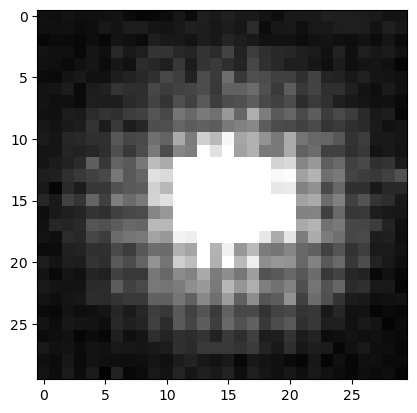

In [424]:
starList.displayStar(333, mode='zoom')

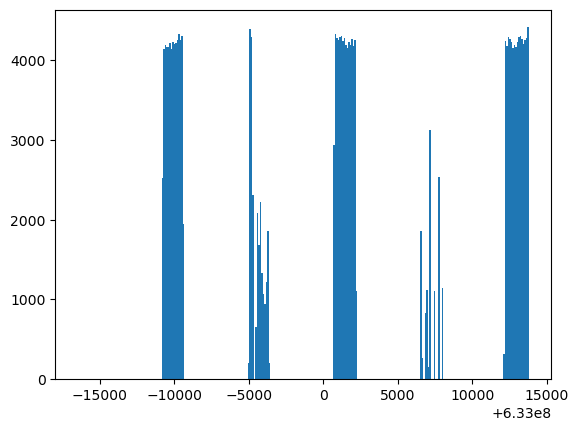

In [448]:
timeData = getData(stars[333])
plt.hist(timeData['TIME'], bins=300)
plt.show()

In [530]:
starData = binStarData(timeData['TIME'])

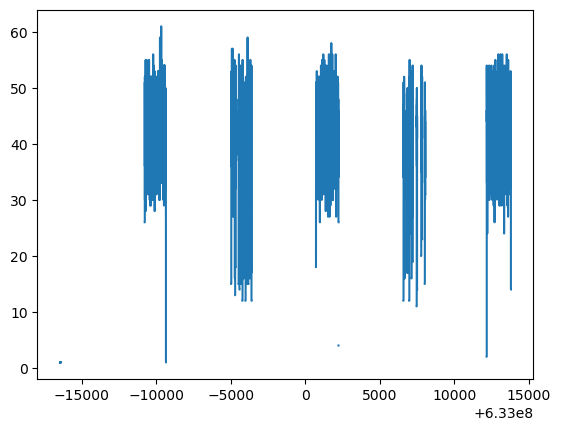

In [450]:
plt.step(starData['time_bin_start'].value, starData['num_events'].value)

In [613]:
r, mt = getSignals(10, starData, False)

KeyboardInterrupt: 

amp 406.4826148505101 mean 0.04955490653349951 stdev 0.39045475738976293


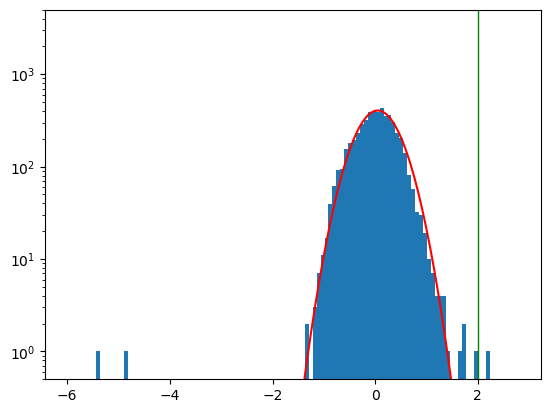

(0.04955490653349951, 0.39045475738976293, 2.0018286934823144)

In [622]:
visualizeSignals(r, 100)

In [623]:
unusualSignalInfo(r, mt, -4, True)

index 1642 with ratio -4.848888829472521 at time 632995257.42296
index 1643 with ratio -5.4313728775720325 at time 632995274.42296


window 5
amp 148.71663277944756 mean -0.2678974581844646 stdev 0.5853306813940465


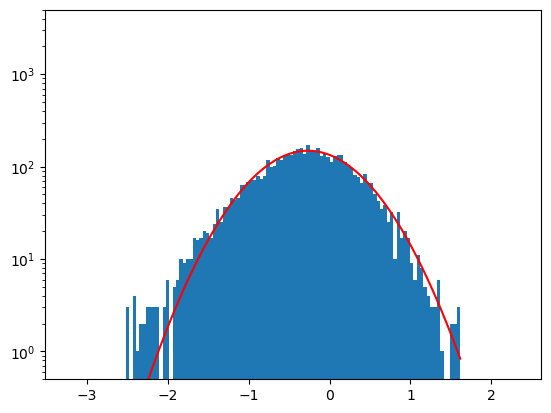

-0.2678974581844646 0.5853306813940465 2.658755948785768
window 10
amp 406.4826148505101 mean 0.04955490653349951 stdev 0.39045475738976293


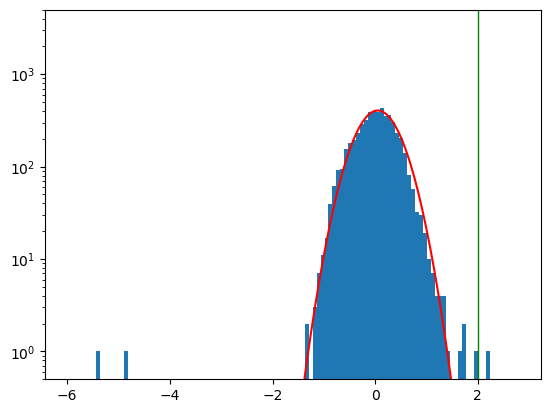

0.04955490653349951 0.39045475738976293 2.0018286934823144


In [628]:
analyzeStar(starData) 

In [626]:
print('ratio', calculateRatio(10, 632995257, starData, True))

bgEvents [44 42 46 40 42 45 40 41 40 49 50 36 46 47 47 13]
signalCounts 16 signalArea 10
bgCounts 668 bgArea 16
bgMeanRate 41.75 signalRate -40.15 totalNoiseRate 8.280247580839598
ratio -4.848888829472521


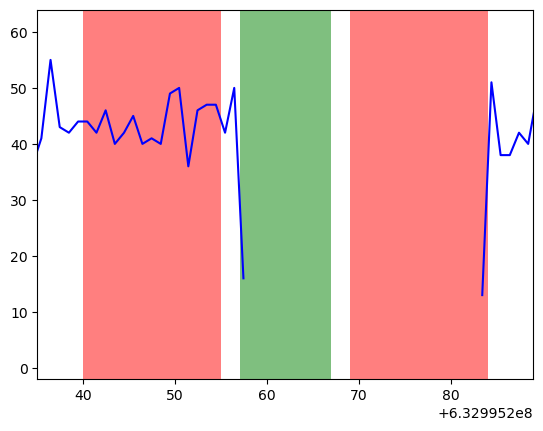

 time_bin_start time_bin_size num_events
                      s                 
--------------- ------------- ----------
632995235.42296           1.0         41
632995236.42296           1.0         55
632995237.42296           1.0         43
632995238.42296           1.0         42
632995239.42296           1.0         44
632995240.42296           1.0         44
            ...           ...        ...
632995282.42296           1.0         --
632995283.42296           1.0         13
632995284.42296           1.0         51
632995285.42296           1.0         38
632995286.42296           1.0         38
632995287.42296           1.0         42
632995288.42296           1.0         40
Length = 54 rows


In [627]:
print(visualizeStarTS(starData, windowStart=632995257, windowSize=10, binsize=1, point=False))